In [1]:
import numpy as np
import scipy
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import scipy.signal as ss
from PIL.Image import open as imread
from PIL import ImageOps as Iops
from skimage.util import random_noise as rn
from skimage.morphology import binary_dilation as bd

In [2]:
im = imread('eight.tif')
g = Iops.grayscale(im)
A = np.array(g)

In [3]:
def showG(im, cmap = 'gray'):
    if np.average(im) < 1:
        im = im*255
    plt.imshow(im, cmap=cmap, vmin=0, vmax=255)
    return plt.show()

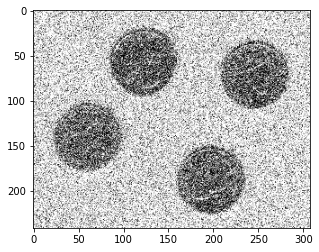

In [4]:
t = rn(A, mode='gaussian', var=0.1)
showG(t)

In [5]:
def gradientImg(im, xk, yk):
    varz = np.arange(0, 0.025, 0.005)
    for var in varz:
        print(var)
        noise = rn(im, mode='gaussian', var=var)
        dx = ss.convolve2d(noise, xk)
        dy = ss.convolve2d(noise, xk)
        fig, ax = plt.subplots(1,2, figsize=((12,16)))
        print(ax.shape)
        ax[0].imshow(dx**2 + dy**2, cmap='gray',vmin=0,vmax=1)
        ax[1].imshow(noise, cmap='gray')
        plt.show()

0.0
(2,)


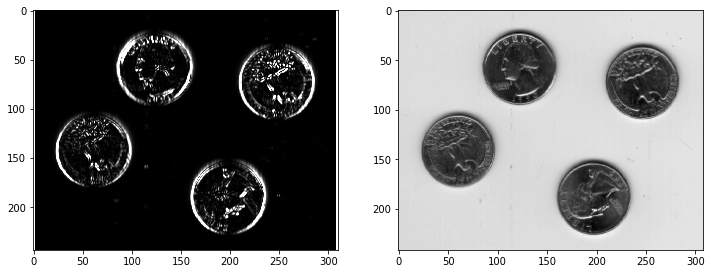

0.005
(2,)


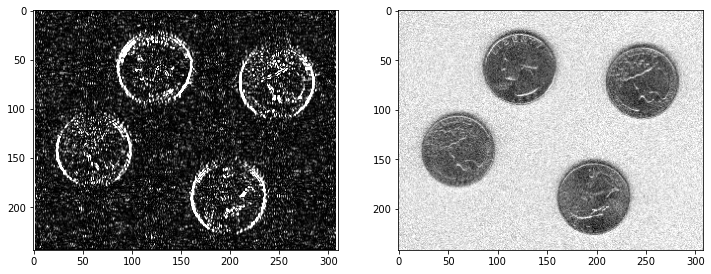

0.01
(2,)


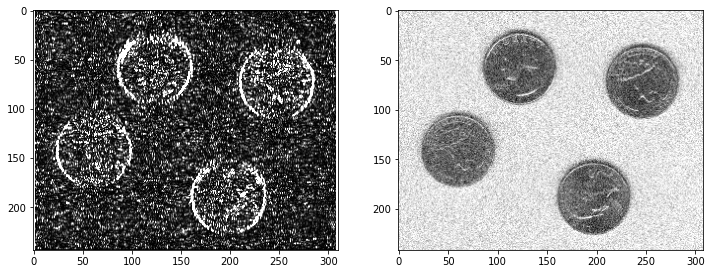

0.015
(2,)


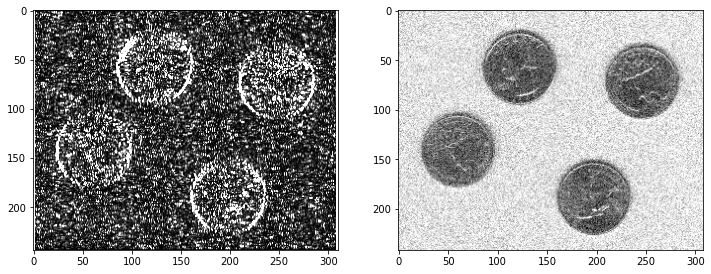

0.02
(2,)


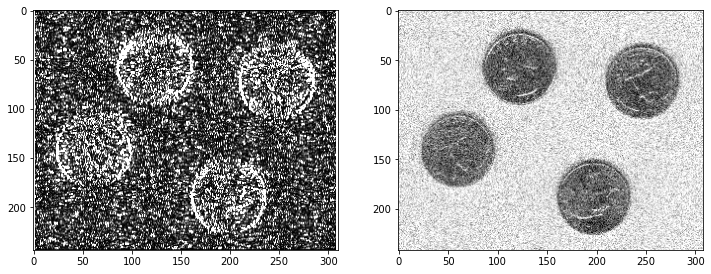

In [6]:
sobelx = np.array([1,0,-1,2,0,-2,1,0,-1]).reshape((3,3))
sobely = np.array([1,2,1,0,0,0,-1,-2,-1]).reshape((3,3))
gradientImg(A, sobelx, sobely)

0.0
(2,)


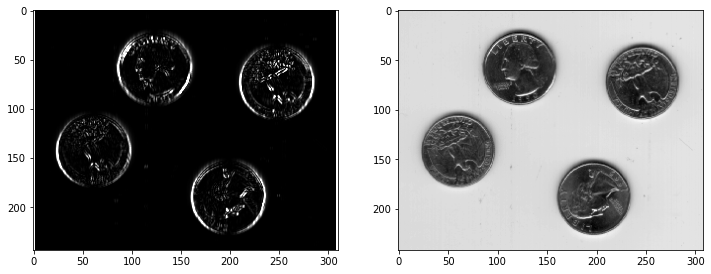

0.005
(2,)


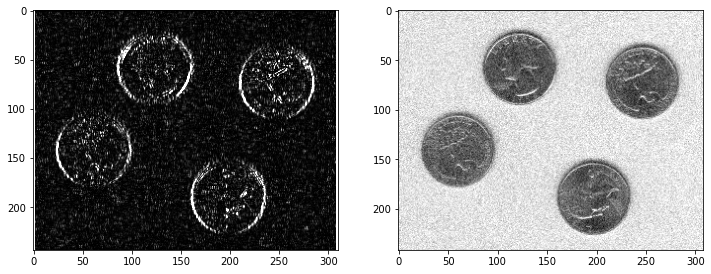

0.01
(2,)


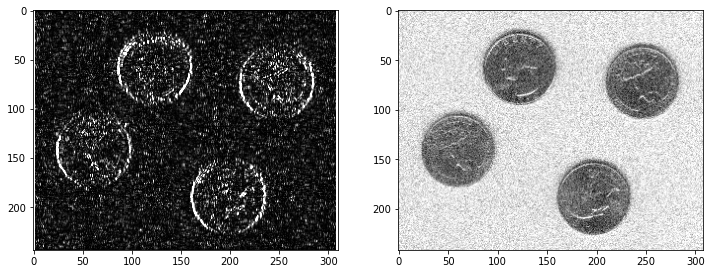

0.015
(2,)


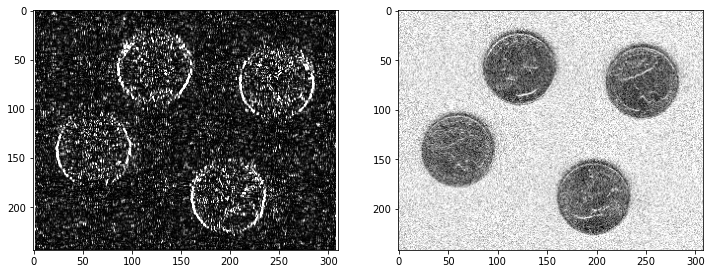

0.02
(2,)


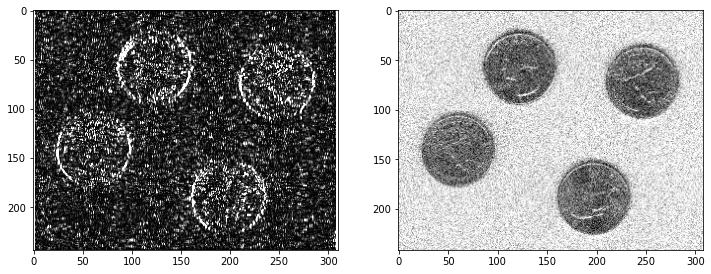

In [7]:
prewittx = np.array([1,0,-1,1,0,-1,1,0,-1]).reshape((3,3))
prewitty = np.array([1,1,1,0,0,0,-1,-1,-1]).reshape((3,3))
gradientImg(A,prewittx,prewitty)

In [8]:
def plot_hist(hist): 
    y, x = hist
    fig, ax = plt.subplots()
    ax.bar(x, y,width = 1)
    ax.set_xlabel('Pixel intensities')
    ax.set_ylabel('Probability')
    return plt.show()

def hist_homebrew(arr, bins):
    count = np.zeros(bins)
    hist = np.arange(bins)
    for i in hist:
        count[i] = sum(arr[arr == i])
    return count, hist

def cdf(im, bins = 256):
    count, intensity = hist_homebrew(np.ravel(im), bins=bins)
    
    prob = count/sum(count)
    return (((bins-1) * np.cumsum(prob)) / (bins-1)), intensity

def inverse(cdf, l = 0.5):
    s, i = cdf
    temp = i[s >= l]
    if(len(temp) == 0):
        return 0
    return np.min(temp)

In [9]:
def midway2(im1, im2):
    s1,i1 = cdf(im1)
    s2,i2 = cdf(im2)
    
    mdws1 = np.zeros_like(im1)
    mdws2 = np.zeros_like(im2)
    
    for y in range(im1.shape[0]):
        for x in range(im1.shape[1]):
            pi1 = im1[y,x]
            pi2 = im2[y,x]
            inv11 = inverse((s1,i1), s1[pi1])
            inv21 = inverse((s2,i2), s1[pi1])
            inv12 = inverse((s1,i1), s2[pi2])
            inv22 = inverse((s2,i2), s2[pi2])
            
            mdws1[y,x] = (inv11 + inv21) / 2
            mdws2[y,x] = (inv12 + inv22) / 2
    return mdws1, mdws2

In [10]:
im1 = imread('movie_flicker1.tif')
g1 = Iops.grayscale(im1)
A1 = np.array(g1)

im2 = imread('movie_flicker2.tif')
g2 = Iops.grayscale(im2)
A2 = np.array(g2)

In [11]:
ms1, ms2 = midway2(A1, A2)

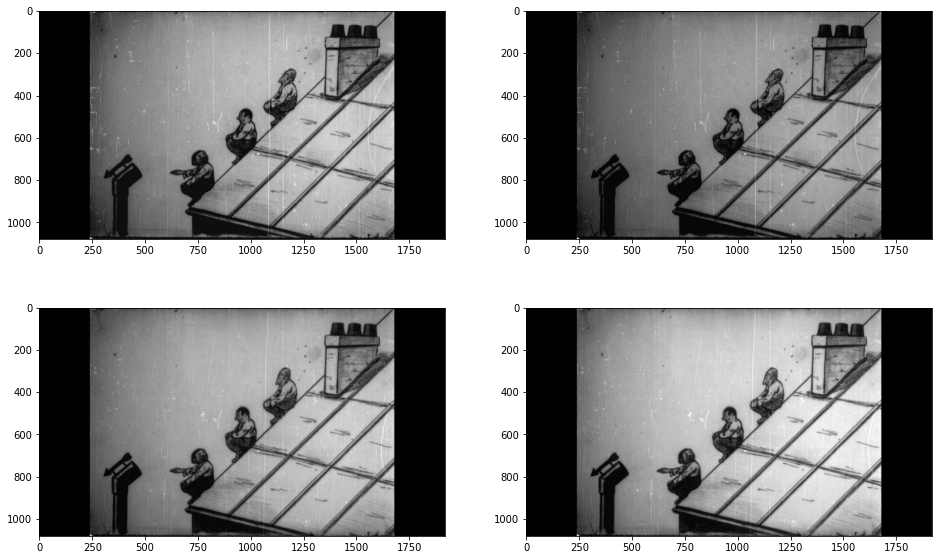

In [12]:
fig, ax = plt.subplots(2,2, figsize=((16,10)))
ax[0,0].imshow(ms1, cmap='gray')
ax[0,1].imshow(A1, cmap='gray')
ax[1,0].imshow(ms2, cmap='gray')
ax[1,1].imshow(A2, cmap='gray')
plt.show()

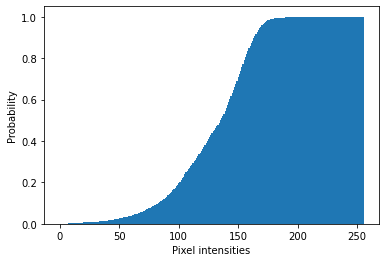

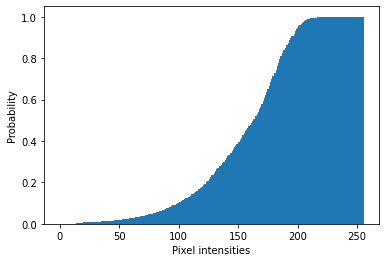

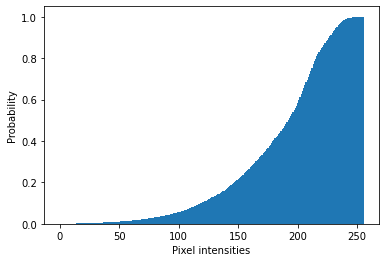

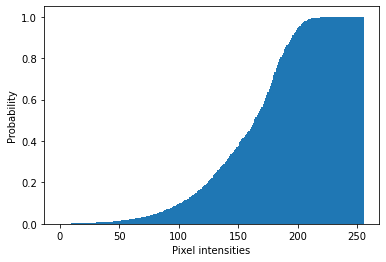

In [13]:
plot_hist(cdf(A1))
plot_hist(cdf(ms1))
plot_hist(cdf(A2))
plot_hist(cdf(ms2))

In [14]:
im3 = imread('trui.png')
g3 = Iops.grayscale(im3)
A3 = np.array(g3)

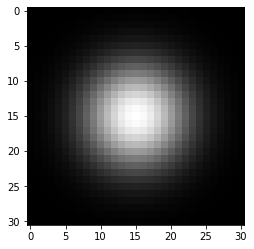

In [15]:
def gausK(sigma):
    n = 3 * sigma
    x, y = np.mgrid[-n:n+1, -n:n+1]
    H = np.exp(-(x**2 + y**2)/(2*sigma**2))
    H *= 1 / (2 * np.pi * sigma**2)
    return H
plt.imshow(gausK(5),cmap='gray')

In [16]:
def fftgausK(sigma):
    n = 0.5/sigma
    x, y = np.mgrid[-n:n+1, -n:n+1]
    H = np.exp(-2*np.pi**2 * sigma**2 * (x**2 + y**2))
    return H

In [17]:
def scale_fft(img,k):
    sz = (img.shape[0] - k.shape[0], img.shape[1] - k.shape[1])
    k = np.pad(k, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2,sz[1]//2)), mode='constant')
    k = ifftshift(k)
    fft = fft2(img)
    fft_filtered = fft * k
    f = ifft2(fft_filtered)
    return np.real(f)

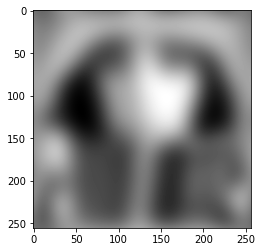

In [18]:
p = scale_fft(A3, fftgausK(0.05))#0.004 - 0.05
plt.imshow(p, cmap='gray')

In [19]:
def scale_fft1dk(img,k):
    sz = (img.shape[0] - k.shape[0], img.shape[1] - k.shape[1])
    k = np.pad(k, (((sz[0]+1)//2, sz[0]//2), ((sz[1]+1)//2,sz[1]//2)), mode='constant')
    k = scipy.fft.ifftshift(k) # Inverse shift of kernel for some reason is needed.
    fft = fft2(img)
    fft_filtered = fft * k
    f = ifft2(fft_filtered)
    return np.real(f)

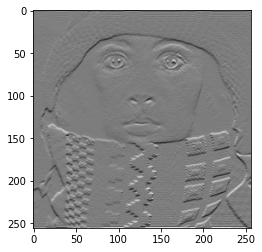

In [20]:
def deriv(im, a, b):
    n1 = (im.shape[0]+1)//2
    n2 = (im.shape[1]+1)//2
    u,v = np.mgrid[-n1:n1,-n2:n2]
    k = (1j*u)**a * (1j*v)**b
    k = fftshift(k)

    fft = fft2(im)
    filtered = fft * k
    return ifft2(filtered)

plt.imshow(np.real(deriv(A3,1,0)), cmap='gray')


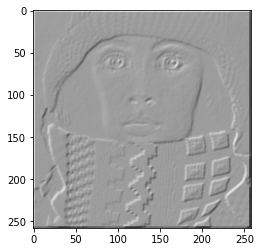

In [21]:
plt.imshow(ss.convolve2d(A3, sobelx) + ss.convolve2d(A3, sobely),cmap='gray')

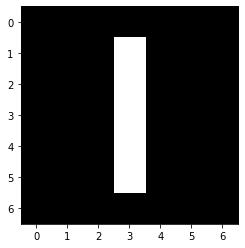

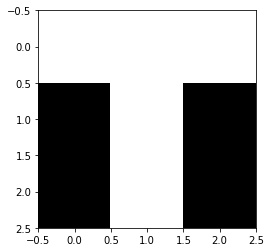

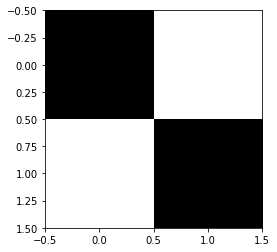

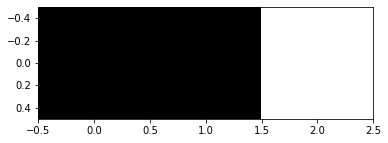

In [22]:
A4 = np.array([0,0,0,0,0,0,0,
               0,0,0,1,0,0,0,
               0,0,0,1,0,0,0,
               0,0,0,1,0,0,0,
               0,0,0,1,0,0,0,
               0,0,0,1,0,0,0,
               0,0,0,0,0,0,0]).reshape((7,7))
plt.imshow(A4,cmap='gray')
plt.show()

m1 = np.array([[1,1,1],
               [0,1,0],
               [0,1,0]])
plt.imshow(m1,cmap='gray')
plt.show()

m2 = np.array([[0,1],
               [1,0]])
plt.imshow(m2,cmap='gray')
plt.show()

m3 = np.array([0,0,1]).reshape((1,3))
plt.imshow(m3,cmap='gray')
plt.show()

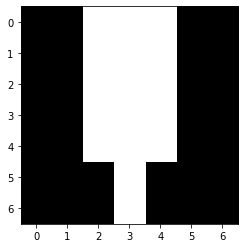

In [23]:
plt.imshow(bd(A4, m1), cmap='gray')

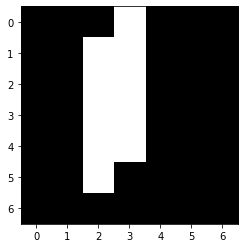

In [24]:
plt.imshow(bd(A4, m2), cmap='gray')

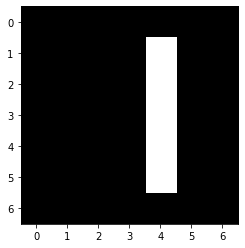

In [25]:
plt.imshow(bd(A4, m3), cmap='gray')

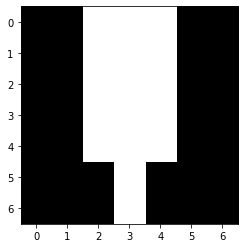

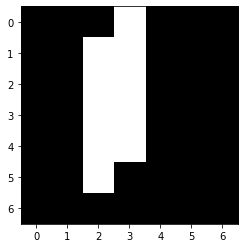

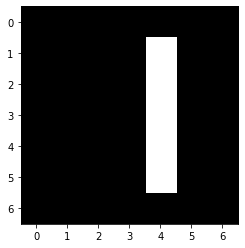

In [28]:
plt.imshow(bd(np.pad(m1, 2), A4), cmap='gray')
plt.show()
plt.imshow(bd(np.pad(m2, (2,3)), A4), cmap='gray')
plt.show()
plt.imshow(bd(np.pad(m3, ((3,3),(2,2))), A4), cmap='gray')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b8b90bcb-ec58-49ce-a1de-eef5c8f2c7b7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>